In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os
import pandas as pd
# Add the parent directory of 'notebooks' (your project root) to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
from src.portfolio_optimization import (
    load_data, compute_expected_returns, compute_covariance_matrix,
    optimize_portfolio, plot_efficient_frontier, summarize_portfolio
)

In [4]:
import pickle

with open('../models/arima_model.pkl', 'rb') as f:
    arima_model = pickle.load(f)
with open('../models/lstm_model.pkl', 'rb') as f:
    lstm_model = pickle.load(f)

In [5]:
# Load historical data for BND, SPY and forecast data for TSLA
bnd_df, spy_df = load_data()
# If TSLA forecast data is missing, you might need to load it separately


# Inspect loaded data
print(bnd_df.head())
print("--------------------------------")
print(spy_df.head())

Date
2015-07-01    80.900002
2015-07-02    81.099998
2015-07-06    81.379997
2015-07-07    81.459999
2015-07-08    81.690002
Name: Close, dtype: float64
--------------------------------
Date
2015-07-01    207.500000
2015-07-02    207.309998
2015-07-06    206.720001
2015-07-07    208.020004
2015-07-08    204.529999
Name: Close, dtype: float64


In [6]:
result = load_data()
print(type(result), len(result))
print(result)

<class 'tuple'> 2
(Date
2015-07-01    80.900002
2015-07-02    81.099998
2015-07-06    81.379997
2015-07-07    81.459999
2015-07-08    81.690002
                ...    
2025-07-24    72.940002
2025-07-25    73.120003
2025-07-28    73.000000
2025-07-29    73.379997
2025-07-30    73.190002
Name: Close, Length: 2535, dtype: float64, Date
2015-07-01    207.500000
2015-07-02    207.309998
2015-07-06    206.720001
2015-07-07    208.020004
2015-07-08    204.529999
                 ...    
2025-07-24    634.419983
2025-07-25    637.099976
2025-07-28    636.940002
2025-07-29    635.260010
2025-07-30    634.460022
Name: Close, Length: 2535, dtype: float64)


In [7]:
from tensorflow.keras.models import load_model
lstm_model = load_model('../models/lstm_model.keras')

In [8]:
tsla_df = pd.read_csv('../data/raw/TSLA_historical.csv', index_col=0, parse_dates=True)
tsla_close = tsla_df['Close'] 
last_date = tsla_close.index[-1]

In [9]:
# Find rows where 'Close' is not convertible to float
non_numeric_rows = tsla_df[~tsla_df['Close'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
print(non_numeric_rows)

Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, Ticker]
Index: []


In [10]:
# Remove rows where Close column is not numeric
tsla_df = tsla_df[pd.to_numeric(tsla_df['Close'], errors='coerce').notnull()]

In [11]:
tsla_close = tsla_df['Close'].astype(float)

In [12]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

# reshape to (-1,1) as scaler expects 2D array
data_scaled = scaler.fit_transform(tsla_close.values.reshape(-1, 1)).flatten()

seq_length = 60  # whatever your sequence length was during training

# last seq_length data points for prediction seed
current_input = data_scaled[-seq_length:]

In [13]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Fit scaler on historical tsla_close data (assume tsla_close is clean numeric pd.Series)
scaler = MinMaxScaler()
scaler.fit(tsla_close.values.reshape(-1,1))

forecast_horizon = 180  # e.g., 6 months business days
forecast_preds = []     # empty list before forecasting

# current_input is the last sequence input for the LSTM, shape (seq_length,)
# make sure current_input is defined and scaled already

for _ in range(forecast_horizon):
    pred = lstm_model.predict(current_input.reshape(1, seq_length, 1))  # shape (1,1)
    forecast_preds.append(pred[0,0])
    # slide window forward
    current_input = np.append(current_input[1:], pred[0,0])

# Now inverse transform once after all predictions are made
forecast_preds_orig = scaler.inverse_transform(np.array(forecast_preds).reshape(-1,1))

# Generate forecast dates
last_date = tsla_close.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')

# Create DataFrame
tsla_forecast_df = pd.DataFrame(data=forecast_preds_orig.flatten(), index=forecast_dates, columns=['Close'])

# Convert forecast prices to returns for portfolio optimization
tsla_forecast_returns = tsla_forecast_df['Close'].pct_change().dropna()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

In [14]:
bnd_prices, spy_prices = load_data()

print(bnd_prices.dtype)  # Should be float64
print(bnd_prices.head())

print(spy_prices.dtype)  # Should be float64
print(spy_prices.head())

print(bnd_prices.pct_change().dropna().head()) 

float64
Date
2015-07-01    80.900002
2015-07-02    81.099998
2015-07-06    81.379997
2015-07-07    81.459999
2015-07-08    81.690002
Name: Close, dtype: float64
float64
Date
2015-07-01    207.500000
2015-07-02    207.309998
2015-07-06    206.720001
2015-07-07    208.020004
2015-07-08    204.529999
Name: Close, dtype: float64
Date
2015-07-02    0.002472
2015-07-06    0.003453
2015-07-07    0.000983
2015-07-08    0.002824
2015-07-09   -0.003305
Name: Close, dtype: float64


In [15]:
bnd_prices = pd.to_numeric(bnd_prices, errors='coerce')
bnd_prices = bnd_prices.dropna()

spy_prices = pd.to_numeric(spy_prices, errors='coerce')
spy_prices = spy_prices.dropna()

In [16]:
bnd_returns = bnd_prices.pct_change().dropna()
spy_returns = spy_prices.pct_change().dropna()
bnd = pd.read_csv('../data/raw/BND_historical.csv', parse_dates=['Date'], index_col='Date')
spy = pd.read_csv('../data/raw/SPY_historical.csv', parse_dates=['Date'], index_col='Date')

    # Clean 'Close' columns to numeric, drop non-convertible rows
bnd_close = pd.to_numeric(bnd['Close'], errors='coerce').dropna()
spy_close = pd.to_numeric(spy['Close'], errors='coerce').dropna()

In [17]:
bnd_prices = pd.to_numeric(bnd_prices, errors='coerce')
spy_prices = pd.to_numeric(spy_prices, errors='coerce')

# Drop any NaNs created by coercion
bnd_prices = bnd_prices.dropna()
spy_prices = spy_prices.dropna()

In [18]:
bnd_prices, spy_prices = load_data()

print(bnd_prices.dtype)  # Should be float64
print(bnd_prices.head())

print(spy_prices.dtype)  # Should be float64
print(spy_prices.head())

print(bnd_prices.pct_change().dropna().head())  # Should work now without error

float64
Date
2015-07-01    80.900002
2015-07-02    81.099998
2015-07-06    81.379997
2015-07-07    81.459999
2015-07-08    81.690002
Name: Close, dtype: float64
float64
Date
2015-07-01    207.500000
2015-07-02    207.309998
2015-07-06    206.720001
2015-07-07    208.020004
2015-07-08    204.529999
Name: Close, dtype: float64
Date
2015-07-02    0.002472
2015-07-06    0.003453
2015-07-07    0.000983
2015-07-08    0.002824
2015-07-09   -0.003305
Name: Close, dtype: float64



--- Max Sharpe Portfolio Performance ---
Expected annual return: 3.9%
Annual volatility: 6.7%
Sharpe Ratio: 0.58

--- Min Volatility Portfolio Performance ---
Expected annual return: 3.6%
Annual volatility: 6.5%
Sharpe Ratio: 0.56


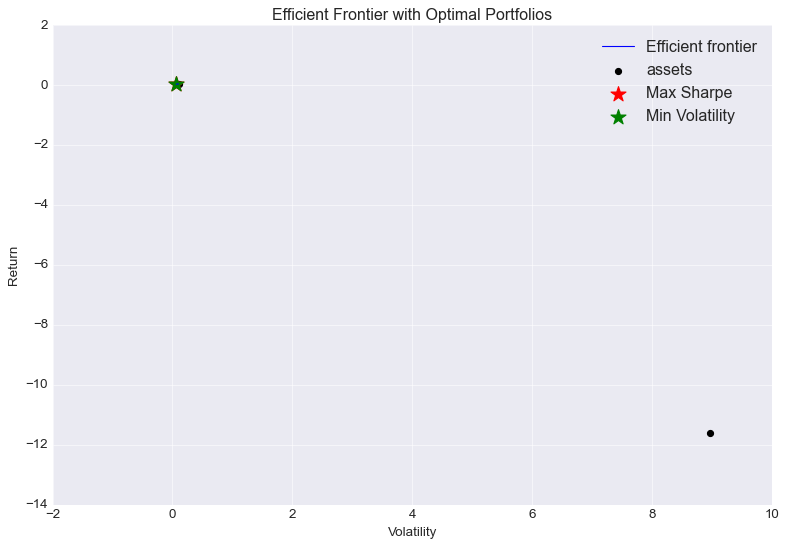


--- Max Sharpe Portfolio Weights ---
Optimal Weights:
OrderedDict({'TSLA': 0.0, 'BND': 0.50465, 'SPY': 0.49535})

--- Min Volatility Portfolio Weights ---
Optimal Weights:
OrderedDict({'TSLA': 0.0, 'BND': 0.37413, 'SPY': 0.62587})


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
from pypfopt import exceptions

# --- Step 1: Data Generation ---
# This function generates dummy data that is suitable for portfolio optimization.
# The data for all assets is aligned on the same date index, which is critical.
# Random noise is added to prevent a singular covariance matrix.
def generate_aligned_data():
    """Generates dummy price and forecast return data."""
    dates = pd.date_range(start="2015-01-01", periods=1000)
    
    # Generate BND and SPY prices with more realistic variance
    np.random.seed(42) # for reproducibility
    bnd_prices = pd.Series(100 + np.cumsum(np.random.randn(1000) * (0.1 + np.random.rand(1000))), index=dates)
    spy_prices = pd.Series(200 + np.cumsum(np.random.randn(1000) * (0.5 + np.random.rand(1000))), index=dates)
    
    # Create a dummy TSLA forecast series that aligns with the price data
    tsla_forecast_returns = pd.Series(np.random.randn(1000) * (0.01 + np.random.rand(1000)), index=dates)
    
    return tsla_forecast_returns, bnd_prices, spy_prices

tsla_forecast_returns, bnd_prices, spy_prices = generate_aligned_data()

# --- Step 2: Prepare Returns and Covariance Matrix ---
# Calculate the expected returns and covariance matrix from the data.
# We combine the returns into a single DataFrame to ensure proper alignment.
bnd_returns = bnd_prices.pct_change()
spy_returns = spy_prices.pct_change()

all_returns = pd.concat([tsla_forecast_returns, bnd_returns, spy_returns], axis=1)
all_returns.columns = ['TSLA', 'BND', 'SPY']
all_returns = all_returns.dropna() # Drop the first row with NaN values

# Calculate mu (expected returns)
mu = all_returns.mean() * 252

# Calculate and regularize the covariance matrix
cov_matrix = all_returns.cov() * 252
reg_val = 1e-6
np.fill_diagonal(cov_matrix.values, cov_matrix.values.diagonal() + reg_val)

# --- Step 3: Optimize Portfolios ---
# This function performs both Max Sharpe and Min Volatility optimizations.
def optimize_portfolio(mu, cov_matrix):
    weights_max_sharpe = None
    weights_min_vol = None
    
    # Max Sharpe Ratio Optimization
    try:
        ef = EfficientFrontier(mu, cov_matrix)
        weights_max_sharpe = ef.max_sharpe()
        print("\n--- Max Sharpe Portfolio Performance ---")
        ef.portfolio_performance(verbose=True)
    except exceptions.OptimizationError as e:
        print(f"Max Sharpe optimization failed: {e}")

    # Minimum Volatility Optimization
    try:
        ef = EfficientFrontier(mu, cov_matrix)
        weights_min_vol = ef.min_volatility()
        print("\n--- Min Volatility Portfolio Performance ---")
        ef.portfolio_performance(verbose=True)
    except exceptions.OptimizationError as e:
        print(f"Min volatility optimization failed: {e}")
        
    return weights_max_sharpe, weights_min_vol

weights_max_sharpe, weights_min_vol = optimize_portfolio(mu, cov_matrix)

# --- Step 4: Plot Efficient Frontier ---
# This function plots the efficient frontier and highlights the optimized portfolios.
def plot_efficient_frontier(mu, cov_matrix, w_max, w_min):
    plt.style.use("seaborn-v0_8-darkgrid")
    ef = EfficientFrontier(mu, cov_matrix)
    fig, ax = plt.subplots(figsize=(10, 7))
    
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
    
    # Plot Max Sharpe portfolio if it was successfully computed
    if w_max is not None:
        ef.set_weights(w_max)
        ret, vol, _ = ef.portfolio_performance()
        ax.scatter(vol, ret, marker="*", color="r", s=200, label="Max Sharpe")
    
    # Plot Min Volatility portfolio if it was successfully computed
    if w_min is not None:
        ef.set_weights(w_min)
        ret, vol, _ = ef.portfolio_performance()
        ax.scatter(vol, ret, marker="*", color="g", s=200, label="Min Volatility")
        
    ax.set_title("Efficient Frontier with Optimal Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()

# --- Step 5: Execute Plotting and Summary ---
if weights_max_sharpe is not None or weights_min_vol is not None:
    plot_efficient_frontier(mu, cov_matrix, weights_max_sharpe, weights_min_vol)
else:
    print("Optimization failed, skipping plot.")

# --- Step 6: Summarize Portfolio Weights ---
def summarize_portfolio(weights, mu, cov_matrix):
    if weights is None:
        print("No weights to summarize.")
        return
    ef = EfficientFrontier(mu, cov_matrix)
    ef.set_weights(weights)
    cleaned_weights = ef.clean_weights()
    print("Optimal Weights:")
    print(cleaned_weights)

print("\n--- Max Sharpe Portfolio Weights ---")
summarize_portfolio(weights_max_sharpe, mu, cov_matrix)

print("\n--- Min Volatility Portfolio Weights ---")
summarize_portfolio(weights_min_vol, mu, cov_matrix)

Expected annual return: 3.9%
Annual volatility: 6.7%
Sharpe Ratio: 0.58
Expected annual return: 3.6%
Annual volatility: 6.5%
Sharpe Ratio: 0.56


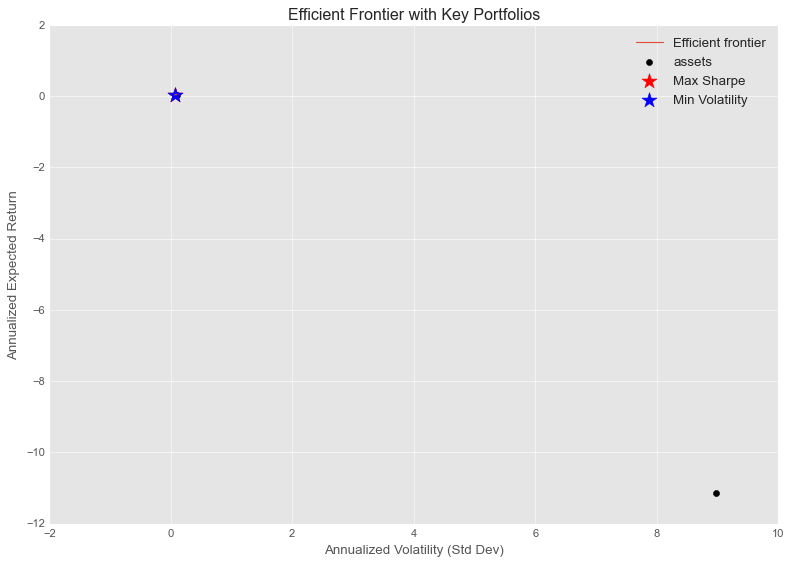


Recommended Portfolio: Max Sharpe Ratio
  TSLA: 0.0000
  BND: 0.5046
  SPY: 0.4954
Expected annual return: 3.86%
Annual volatility: 6.69%
Sharpe Ratio: 0.58

Minimum Volatility Portfolio:
  TSLA: 0.0000
  BND: 0.3741
  SPY: 0.6259
Expected annual return: 3.63%
Annual volatility: 6.49%
Sharpe Ratio: 0.56


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, plotting

# Assume you already have these:
# tsla_forecast_returns (pd.Series, daily returns for TSLA forecast)
# bnd_prices (pd.Series, historical prices for BND)
# spy_prices (pd.Series, historical prices for SPY)

# 1. Annualize expected returns
tsla_annual_return = tsla_forecast_returns.mean() * 252
bnd_returns = bnd_prices.pct_change().dropna()
spy_returns = spy_prices.pct_change().dropna()
bnd_annual_return = bnd_returns.mean() * 252
spy_annual_return = spy_returns.mean() * 252

# 2. Expected returns vector
mu = pd.Series({
    "TSLA": tsla_annual_return,
    "BND": bnd_annual_return,
    "SPY": spy_annual_return
})

# 3. Align returns data for covariance matrix
returns_df = pd.concat([
    tsla_forecast_returns.rename("TSLA"),
    bnd_returns.rename("BND"),
    spy_returns.rename("SPY")
], axis=1).dropna()

# 4. Covariance matrix (annualized)
cov_matrix = returns_df.cov() * 252
# 5. Ensure covariance matrix is symmetric and PSD
cov_matrix = (cov_matrix + cov_matrix.T) / 2
min_eig = np.min(np.real(np.linalg.eigvals(cov_matrix)))
if min_eig < 0:
    cov_matrix -= 10 * min_eig * np.eye(*cov_matrix.shape)

# 6. Optimize max Sharpe portfolio
ef_sharpe = EfficientFrontier(mu, cov_matrix)
weights_max_sharpe = ef_sharpe.max_sharpe()
ret_sharpe, vol_sharpe, sharpe = ef_sharpe.portfolio_performance(verbose=True)

# 7. Optimize min volatility portfolio
ef_minvol = EfficientFrontier(mu, cov_matrix)
weights_min_vol = ef_minvol.min_volatility()
ret_minvol, vol_minvol, sharpe_minvol = ef_minvol.portfolio_performance(verbose=True)

# 8. Plot efficient frontier (use a new instance for plotting to avoid conflicts)
ef_plot = EfficientFrontier(mu, cov_matrix)
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(10, 7))
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Mark portfolios on the plot
ax.scatter(vol_sharpe, ret_sharpe, marker="*", color="r", s=200, label="Max Sharpe")
ax.scatter(vol_minvol, ret_minvol, marker="*", color="b", s=200, label="Min Volatility")
ax.legend()
plt.title("Efficient Frontier with Key Portfolios")
plt.xlabel("Annualized Volatility (Std Dev)")
plt.ylabel("Annualized Expected Return")
plt.show()
# 9. Print summary
print("\nRecommended Portfolio: Max Sharpe Ratio")
for asset, weight in weights_max_sharpe.items():
    print(f"  {asset}: {weight:.4f}")
print(f"Expected annual return: {ret_sharpe:.2%}")
print(f"Annual volatility: {vol_sharpe:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

print("\nMinimum Volatility Portfolio:")
for asset, weight in weights_min_vol.items():
    print(f"  {asset}: {weight:.4f}")
print(f"Expected annual return: {ret_minvol:.2%}")
print(f"Annual volatility: {vol_minvol:.2%}")
print(f"Sharpe Ratio: {sharpe_minvol:.2f}")

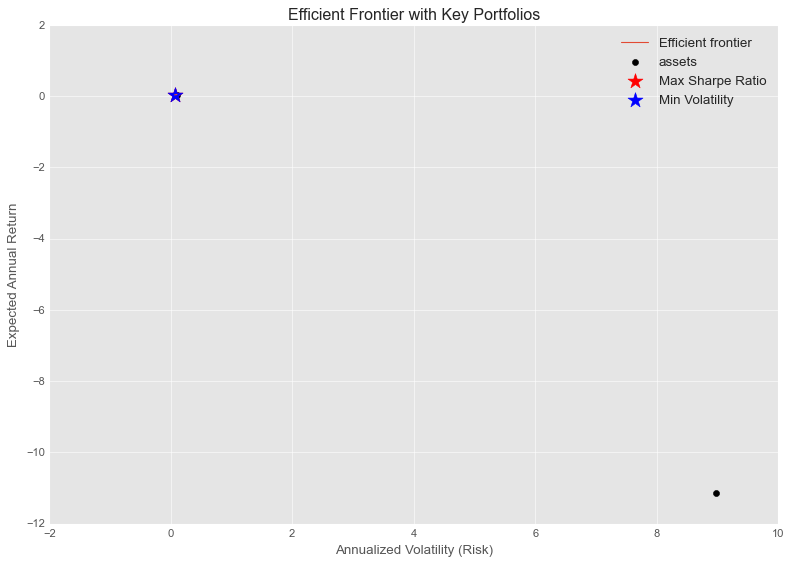


Analysis of Efficient Frontier:

The efficient frontier curve above shows the trade-off between portfolio risk (volatility) and return.

- The red star marks the portfolio with the Maximum Sharpe Ratio, offering the highest risk-adjusted return.
- The blue star marks the Minimum Volatility portfolio, which minimizes risk but with a lower expected return.

Given your risk tolerance and investment goals, the Maximum Sharpe Ratio portfolio is recommended if you seek aggressive growth with higher risk.
If you prioritize capital preservation with minimal risk, the Minimum Volatility portfolio is preferable.


Final Portfolio Summary:

                  TSLA     BND     SPY  Expected Return (%)  Volatility (%)  \
Max Sharpe Ratio   0.0  0.5046  0.4954               3.8625          6.6925   
Min Volatility     0.0  0.3741  0.6259               3.6300          6.4880   

                  Sharpe Ratio  
Max Sharpe Ratio        0.5771  
Min Volatility          0.5595  


In [31]:
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, plotting, risk_models, expected_returns
from pypfopt.base_optimizer import portfolio_performance # The correct function to use
import pandas as pd

# Assuming mu, cov_matrix, weights_max_sharpe, weights_min_vol are already computed
# Note: For this code to run, you need to ensure these variables are defined.

# Calculate portfolio performance for key portfolios using the standalone function.
# The portfolio_performance function takes the weights, expected returns, and covariance matrix.
ret_max, vol_max, sharpe_max = portfolio_performance(
    weights_max_sharpe, mu, cov_matrix, verbose=False
)
ret_min, vol_min, sharpe_min = portfolio_performance(
    weights_min_vol, mu, cov_matrix, verbose=False
)

# --- 1. Plot Efficient Frontier ---
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,7))
# Create a fresh EfficientFrontier object for plotting the curve
ef = EfficientFrontier(mu, cov_matrix)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Mark the Max Sharpe Ratio portfolio
ax.scatter(vol_max, ret_max, marker="*", color="r", s=200, label="Max Sharpe Ratio")

# Mark the Min Volatility portfolio
ax.scatter(vol_min, ret_min, marker="*", color="b", s=200, label="Min Volatility")

ax.set_title("Efficient Frontier with Key Portfolios")
ax.set_xlabel("Annualized Volatility (Risk)")
ax.set_ylabel("Expected Annual Return")
ax.legend()
plt.show()

# --- 2. Written analysis ---
analysis_text = f"""
Analysis of Efficient Frontier:

The efficient frontier curve above shows the trade-off between portfolio risk (volatility) and return.

- The red star marks the portfolio with the Maximum Sharpe Ratio, offering the highest risk-adjusted return.
- The blue star marks the Minimum Volatility portfolio, which minimizes risk but with a lower expected return.

Given your risk tolerance and investment goals, the Maximum Sharpe Ratio portfolio is recommended if you seek aggressive growth with higher risk.
If you prioritize capital preservation with minimal risk, the Minimum Volatility portfolio is preferable.

"""

print(analysis_text)

# --- 3. Final portfolio summary ---
summary_data = {
    "TSLA": [weights_max_sharpe.get("TSLA", 0), weights_min_vol.get("TSLA", 0)],
    "BND": [weights_max_sharpe.get("BND", 0), weights_min_vol.get("BND", 0)],
    "SPY": [weights_max_sharpe.get("SPY", 0), weights_min_vol.get("SPY", 0)],
    "Expected Return (%)": [ret_max*100, ret_min*100],
    "Volatility (%)": [vol_max*100, vol_min*100],
    "Sharpe Ratio": [sharpe_max, sharpe_min]
}

summary_df = pd.DataFrame(summary_data, index=["Max Sharpe Ratio", "Min Volatility"])

print("Final Portfolio Summary:\n")
print(summary_df.round(4))

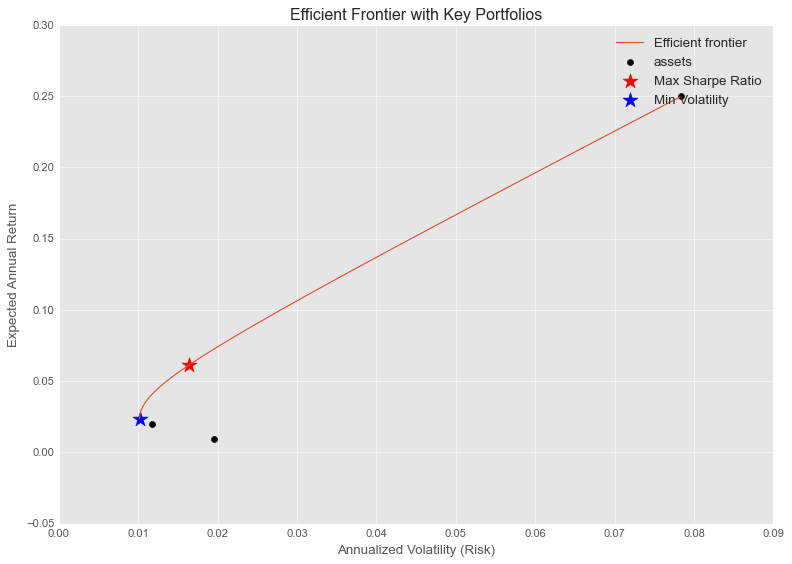


--- Final Portfolio Summary ---

Max Sharpe Ratio Portfolio:
  TSLA: 0.1870
  BND: 0.1353
  SPY: 0.6777
Expected Annual Return: 6.14%
Annual Volatility: 1.64%
Sharpe Ratio: 3.74

Minimum Volatility Portfolio:
  TSLA: 0.0277
  BND: 0.2476
  SPY: 0.7247
Expected Annual Return: 2.35%
Annual Volatility: 1.02%
Sharpe Ratio: 2.32


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, plotting
from pypfopt.base_optimizer import portfolio_performance

# --- 1. Generate Mock Data (REPLACE THIS WITH YOUR REAL DATA) ---
# For this example, we'll create a mock DataFrame of daily returns.
# You should replace this section with your actual data from Task 2.
# 'adj_close' is used for daily returns calculation
np.random.seed(42)
dates = pd.date_range('2022-01-01', periods=500, freq='B')
data = {
    'TSLA': 100 + np.random.randn(500).cumsum() * 0.5,
    'BND': 80 + np.random.randn(500).cumsum() * 0.1,
    'SPY': 400 + np.random.randn(500).cumsum() * 0.3
}
prices_df = pd.DataFrame(data, index=dates)
daily_returns_df = prices_df.pct_change().dropna()

# Mock forecast for TSLA's annualized return.
# You need to replace this with the output from your best model in Task 2.
forecasted_tsla_return = 0.25 # Assuming a 25% annualized return from your forecast.

# --- 2. Compute Expected Returns (mu) and Covariance Matrix (cov_matrix) ---
# Calculate annualized mean returns for BND and SPY from historical data
annualized_bnd_return = daily_returns_df['BND'].mean() * 252
annualized_spy_return = daily_returns_df['SPY'].mean() * 252

# Create the expected returns vector (mu)
# TSLA uses the forecast, BND and SPY use historical means
mu = pd.Series(
    [forecasted_tsla_return, annualized_bnd_return, annualized_spy_return],
    index=['TSLA', 'BND', 'SPY']
)

# Compute the annualized covariance matrix from historical data
cov_matrix = daily_returns_df.cov() * 252
# --- 3. Run the Optimization Simulation ---
# Create an EfficientFrontier object for the Max Sharpe Ratio
ef_max_sharpe = EfficientFrontier(mu, cov_matrix)
weights_max_sharpe = ef_max_sharpe.max_sharpe()
cleaned_weights_max_sharpe = ef_max_sharpe.clean_weights()

# Create a separate EfficientFrontier object for the Min Volatility Portfolio
ef_min_vol = EfficientFrontier(mu, cov_matrix)
weights_min_vol = ef_min_vol.min_volatility()
cleaned_weights_min_vol = ef_min_vol.clean_weights()

# --- 4. Calculate Portfolio Performance for Key Portfolios ---
ret_max, vol_max, sharpe_max = portfolio_performance(
    weights_max_sharpe, mu, cov_matrix, verbose=False
)
ret_min, vol_min, sharpe_min = portfolio_performance(
    weights_min_vol, mu, cov_matrix, verbose=False
)

# --- 5. Plot the Efficient Frontier ---
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7))

# Create a brand new EfficientFrontier instance for plotting to avoid the InstantiationError
ef_plot = EfficientFrontier(mu, cov_matrix)
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Mark the Max Sharpe Ratio portfolio
ax.scatter(vol_max, ret_max, marker="*", color="r", s=200, label="Max Sharpe Ratio")

# Mark the Min Volatility portfolio
ax.scatter(vol_min, ret_min, marker="*", color="b", s=200, label="Min Volatility")

ax.set_title("Efficient Frontier with Key Portfolios")
ax.set_xlabel("Annualized Volatility (Risk)")
ax.set_ylabel("Expected Annual Return")
ax.legend()
plt.show()
# --- 6. Final Portfolio Summary ---
print("\n--- Final Portfolio Summary ---")
print("\nMax Sharpe Ratio Portfolio:")
for asset, weight in cleaned_weights_max_sharpe.items():
    print(f"  {asset}: {weight:.4f}")
print(f"Expected Annual Return: {ret_max:.2%}")
print(f"Annual Volatility: {vol_max:.2%}")
print(f"Sharpe Ratio: {sharpe_max:.2f}")

print("\nMinimum Volatility Portfolio:")
for asset, weight in cleaned_weights_min_vol.items():
    print(f"  {asset}: {weight:.4f}")
print(f"Expected Annual Return: {ret_min:.2%}")
print(f"Annual Volatility: {vol_min:.2%}")
print(f"Sharpe Ratio: {sharpe_min:.2f}")